In [2]:
from PIL import Image
from libtiff import TIFF
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import os
import torch
import torchvision.transforms as transforms

from ImagenetDataset import get_zipped_dataloaders, FULL_SET_PATH
from utils import getLabelToClassMapping

%matplotlib inline

In [3]:
img_data_path = os.path.join(os.getcwd(), 'plastic_data', 'blackvalue_aufnahmen_14.11.2017')

print(img_data_path)
file_list = [x for x in os.listdir(img_data_path) if x != 'Thumbs.db']
print(len(file_list))

rgb_files_list = [x for x in file_list if "_A.tif" in x]
bin_files_list = [x for x in file_list if "_A_alpha" in x]
spec_files_list = [x for x in file_list if "_B.tif" in x]
print(len(rgb_files_list))
print(len(bin_files_list))
print(len(spec_files_list))

rgb_files_list.sort()
bin_files_list.sort()
spec_files_list.sort()
print(rgb_files_list[0:3])
print(bin_files_list[0:3])
print(spec_files_list[0:3])

data_rec_files = list(zip(rgb_files_list, bin_files_list, spec_files_list))
print(len(data_rec_files))
print(data_rec_files[0])

/home/alex/Projects/Studium/anytimeDnn/data/plastic_data/blackvalue_aufnahmen_14.11.2017
246
82
82
82
['abs1_0000_A.tif', 'abs1_0001_A.tif', 'abs1_0002_A.tif']
['abs1_0000_A_alpha.tif', 'abs1_0001_A_alpha.tif', 'abs1_0002_A_alpha.tif']
['abs1_0000_B.tif', 'abs1_0001_B.tif', 'abs1_0002_B.tif']
82
('abs1_0000_A.tif', 'abs1_0000_A_alpha.tif', 'abs1_0000_B.tif')


In [4]:
# create data_loader
train_loader, val_loader, test_loader = get_zipped_dataloaders('./imagenet_full', batch_size=1, use_valid=True)
#_, _, test_loader = get_zipped_dataloaders('./imagenet_red', batch_size=1)

#train_loader, val_loader, test_loader = get_zipped_dataloaders('./imagenet_red', batch_size=1)

label_class_map = getLabelToClassMapping('./imagenet_full')

./imagenet_full/index-train.txt
./imagenet_full/index-val.txt
./imagenet_full/index-val.txt


In [5]:
a = len(train_loader)
b = len(val_loader)
c = len(test_loader)

print(a)
print(b)
print(c)
print(a + b + c)
print(f'Data for training: {a + b}')

31891
3543
3953
39387
Data for training: 35434


In [6]:
class_count_map = dict()

per_class_val = dict()
per_class_train = dict()
per_class_test = dict()

# init class count
for entry in label_class_map:
    class_count_map[entry] = 0
    per_class_test[entry] = 0
    per_class_train[entry] = 0
    per_class_val[entry] = 0


for _, target in iter(train_loader):
    #class_count_map[label_class_map[target.item()]] += 1
    per_class_train[label_class_map[target.item()]] += 1

for _, target in iter(val_loader):
    #class_count_map[label_class_map[target.item()]] += 1
    per_class_val[label_class_map[target.item()]] += 1

for _, target in iter(test_loader):
    per_class_test[label_class_map[target.item()]] += 1


In [7]:
# calculate dataframe for images per classes
import pandas as pd 
print(len(class_count_map.keys()))

df = pd.DataFrame.from_dict(class_count_map, orient='index')
#df = df.sort_values(0)

df_train = pd.DataFrame.from_dict(per_class_train, orient='index')
df_val = pd.DataFrame.from_dict(per_class_val, orient='index')
df_test = pd.DataFrame.from_dict(per_class_test, orient='index')

40


In [8]:
df = pd.concat([df_train, df_val, df_test], axis=1, ignore_index=True)
df = df.rename(columns={0:'Train-Set', 1:'Validation-Set', 2: 'Test-Set'})

print(df.head(4))
df = df.assign(Total=lambda d: d.sum(1)).sort_values('Total', axis=0)
print(df.head(4))
df.to_csv('./temp.csv')
#a = df.groupby([0, 1, 2])['sessions_count'].sum().unstack(fill_value=0)
#a = a.assign(tmp=a.sum(axis=1)).sort_values('tmp', ascending=False).drop('tmp', 1).head(5)

                   Train-Set  Validation-Set  Test-Set
Tulipa gesneriana        798             108       101
angiosperm               813              95       101
aster                    784              89        97
beer                     807              96       101
          Train-Set  Validation-Set  Test-Set  Total
gazania         694              67        85    846
pea             732              77        90    899
tinfoil         744              75        91    910
eggplant        729              93        92    914


                       Train-Set  Validation-Set  Test-Set  Total
gazania                      694              67        85    846
pea                          732              77        90    899
tinfoil                      744              75        91    910
eggplant                     729              93        92    914
bell pepper                  732             101        93    926
mango                        767              85        95    947
gorse                        771              90        96    957
tom                          769              95        96    960
lime                         788              80        97    965
aster                        784              89        97    970
raspberry                    802              80        98    980
wild calla                   810              76        99    985
roseate spoonbill            810              80        99    989
thatch                       796              96       100    992
spice     

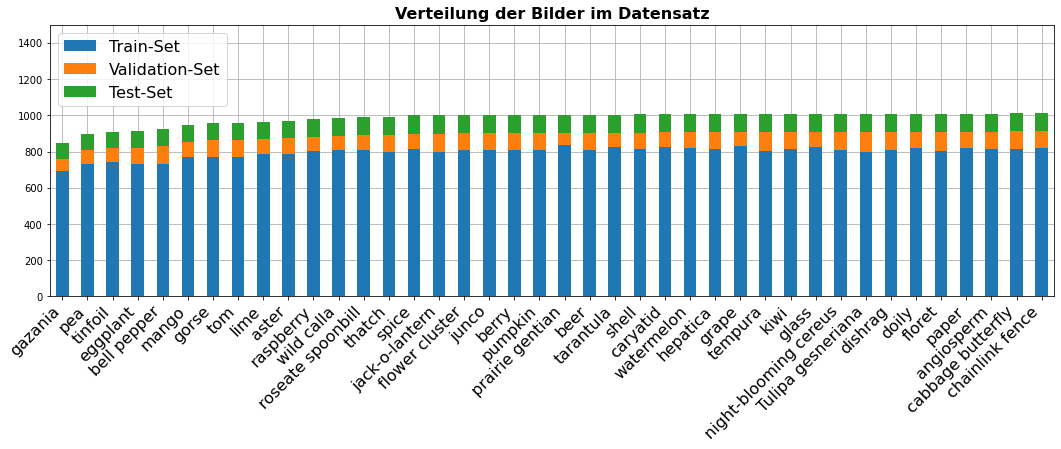

In [23]:
# plot Images per Classes

def plotDf(df):
    #axes = df.plot.bar(subplots=True, figsize=(18, 5), rot=45, zorder=4)
    axes = df.plot.bar(stacked=True, figsize=(18, 5), rot=45, zorder=4)
    #ax = axes[0]
    ax = axes
    ax.grid(zorder=0)
    ax.set_title('Verteilung der Bilder im Datensatz', fontsize=16, fontweight='bold')
    #ax.set_xticklabels(class_count_map.keys(), rotation=45, ha='right')
    ax.set_xticklabels(df.index, rotation=45, ha='right')
    #ax.set_xticklabels(df.loc[0], rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylim((0, 1500))
    ax.legend(loc=2, prop={'size': 16})
    #ax.get_legend().remove()

df = pd.concat([df_train, df_val, df_test], axis=1, ignore_index=True)
df = df.rename(columns={0:'Train-Set', 1:'Validation-Set', 2: 'Test-Set'})
df = df.assign(Total=lambda d: d.sum(1)).sort_values('Total', axis=0)
print(df)
del df['Total']
#df.head()
df.iloc[:,0]
df.index
plotDf(df)


In [98]:
# Plot the test_set values
class_count_map = dict()
label_class_map = getLabelToClassMapping('./imagenet_red')
# init class count
for entry in label_class_map:
    class_count_map[entry] = 0

for _, target in iter(test_loader):
    class_count_map[label_class_map[target.item()]] += 1

for key in class_count_map:
    print(f'{key}: {class_count_map[key]}')

./imagenet_red/index-val.txt
Tulipa gesneriana: 12
angiosperm: 12
aster: 12
beer: 12
bell pepper: 11
berry: 12
cabbage butterfly: 12
caryatid: 12
chainlink fence: 12
dishrag: 12
doily: 12
eggplant: 11
floret: 12
flower cluster: 12
gazania: 10
glass: 12
gorse: 12
grape: 12
hepatica: 12
jack-o-lantern: 12
junco: 12
kiwi: 12
lime: 12
mango: 11
night-blooming cereus: 12
paper: 12
pea: 11
prairie gentian: 12
pumpkin: 12
raspberry: 12
roseate spoonbill: 12
shell: 12
spice: 12
tarantula: 12
tempura: 12
thatch: 12
tinfoil: 11
tom: 12
watermelon: 12
wild calla: 12


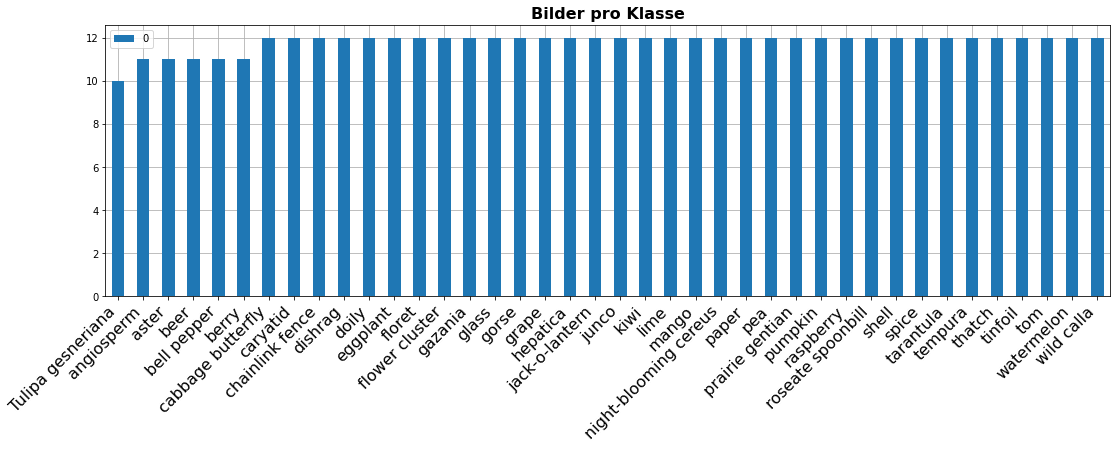

In [100]:
df = pd.DataFrame.from_dict(class_count_map, orient='index')
df = df.sort_values(0)
plotDf(df)